Para evaluar una posición usando turochamp hacer lo siguiente:
1.	Valor de las piezas (getPiecesValue): Darle un valor para cada pieza que se encuentre en el tablero, Turin y Champernowne proponían 1 para los peones, 3 para los caballos, 3.5 para los alfiles, 5 las torres y 10 para la reina.
2.	Evaluar la movilidad (getMobility): Para la reina, la torre, los caballos y los alfiles contamos como valor de movilidad la raíz cuadrada del número de posibles movimientos que tiene cada pieza, si tenemos una captura la contamos como 2 en vez de 1.
3.	Seguridad de las piezas  (pieceSecurity): Para la torre, el alfil y el caballo añadimos 1 punto si está defendido y 1.5 si está defendido por lo menos dos veces.
4.	Mobilidad del rey (kingMobility): Hacemos lo mismo que en la movilidad de las piezas pero para el rey.
5.	Seguridad del rey (kingSecurity): Para el rey asumimos como si una reina estuviera en nuestro lugar y calculamos su movilidad, después substraemos ese resultado.
6.	Enroque (castleValue): Añadimos 1 punto si es posible hacer un enroque y añadimos otro si fuera posible realizarlo en el siguiente movimiento.
7.	Valor para los peones (pawnValues): En este caso añadimos 0.2 puntos por cada rango avanzado por cada peón y 0.3 si estuviera defendido.
8.	Mates y jaques (mateThreats): Añadimos 1 punto por cada amenaza de mate.


In [ ]:
!pip install chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 4.8 MB/s eta 0:00:00


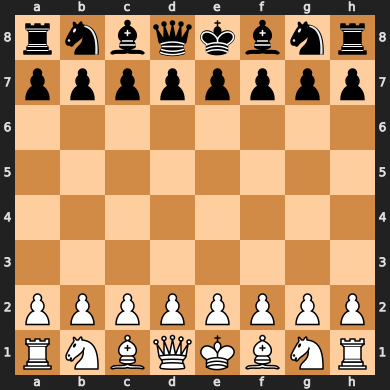

In [ ]:
import chess
import numpy as np

board = chess.Board()
board

In [ ]:
def getPiecesValue(board):
  white = board.occupied_co[chess.WHITE]
  black = board.occupied_co[chess.BLACK]
  return (
        1 * (chess.popcount(white & board.pawns) - 
        chess.popcount(black & board.pawns)) +
        3 * (chess.popcount(white & board.knights) - 
             chess.popcount(black & board.knights)) +
        3.5 * (chess.popcount(white & board.bishops) - 
               chess.popcount(black & board.bishops)) +
        5 * (chess.popcount(white & board.rooks) - 
             chess.popcount(black & board.rooks)) +
        9 * (chess.popcount(white & board.queens) - 
             chess.popcount(black & board.queens))
  )

getPiecesValue(board)

-215

In [ ]:
def getMobility(board):
  res = 0

  # Iterate over all squares on the board
  for square in chess.SQUARES:
      piece = board.piece_at(square)

      # If the piece is a king or a pawn stop
      if piece is None or piece.color != board.turn or piece.piece_type == 1 or piece.piece_type==6:
          continue
      
      moves = board.legal_moves
      aux = 0
      for move in moves:
          m = str(move)[0:2]
          s = chess.square_name(square)
          
          if s == m:
              aux = aux + 1

      res = res + aux

  return np.sqrt(res)

mobility = getMobility(board)
print(mobility)

5.196152422706632


In [ ]:
def pieceSecurity(board):
  defending_color = board.turn
  res = 0

  # loop through all the squares on the board
  for square in chess.SQUARES:
      # check if the square has a piece on it and if it is a N, B or R
      piece = board.piece_at(square)
      if piece and (piece.piece_type == 4 or piece.piece_type == 2 or piece.piece_type==3):
          # check if the piece on the square is of the defending color
          if board.color_at(square) == defending_color:
              # get the attackers of the piece on the square
              attackers = board.attackers(defending_color, square)
              # check if there's more than one defender in the square with a piece
              aux = len(list(attackers))

              if aux > 1:
                res = res + 1.5
              else:
                res = res + aux
  return res

  # print the defended pieces
print("Result:", pieceSecurity(board))

Result: 2.5


In [ ]:
def kingMobility(board):
  res = 0

  # Iterate over all squares on the board
  for square in chess.SQUARES:
      piece = board.piece_at(square)

      if piece is None or piece.color != board.turn or piece.piece_type != 6:
          continue
      
      moves = board.legal_moves
      aux = 0
      for move in moves:
          m = str(move)[0:2]
          s = chess.square_name(square)
          
          if s == m:
              aux = aux + 1

      res = res + aux

  return np.sqrt(res)

kingMob = kingMobility(board)
print(kingMob)

1.7320508075688772


In [ ]:
def kingSecurity(board):
    #Create a copy of the actual board
    board2 = board.copy()
    kingPos = board2.king(board.turn)
    
    #Replace a queen for the king
    board2.set_piece_at(kingPos, chess.Piece(chess.QUEEN, chess.WHITE))
    
    moves = board2.legal_moves
    aux = 0
    for move in moves:
        m = str(move)[0:2]
        s = chess.square_name(kingPos)
        
        if s == m:
            aux = aux + 1

    return -np.sqrt(aux)


print(kingSecurity(board))

-0.0


In [ ]:
def castleValue(board):
  # count the number of possible castles
  num_castles = 0
  if board.turn:
    if board.has_kingside_castling_rights(chess.WHITE):
        num_castles += 1
    if board.has_queenside_castling_rights(chess.WHITE):
        num_castles += 1
  else:
    if board.has_kingside_castling_rights(chess.BLACK):
        num_castles += 1
    if board.has_queenside_castling_rights(chess.BLACK):
        num_castles += 1
  
  moves = board.legal_moves
  for move in moves:
    if str(board.san(move)) == "O-O":
      num_castles += 1
    if str(board.san(move)) == "O-O-O":
      num_castles +=1
      
  return num_castles

castleVal = castleValue(board)

print(castleVal)

0


In [ ]:
def pawnValues(board):
  defending_color = board.turn
  res = 0

  # loop through all the squares on the board
  for square in chess.SQUARES:
      # check if the square has a piece on it and if it is a R,B or K
      piece = board.piece_at(square)
      if piece and piece.piece_type == 1 and piece.color==defending_color:
          # check if the piece on the square is of the defending color
          fila = chess.square_rank(square)

          if defending_color:
            if fila >=2:
              res = res + (fila*0.2) - 0.2
          else:
            aux = 7-fila
            if aux >=2:
              res = res + (fila*0.2) - 0.2

          if board.color_at(square) == defending_color:
              # get the attackers of the piece on the square
              attackers = board.attackers(defending_color, square)
              # check if there's more than one defender in the square with a piece
              aux = len(list(attackers))

              if aux >= 1:
                res = res + 0.3



  return res

pawnVal = pawnValues(board)

print(pawnVal)

1.4000000000000001


In [ ]:
def mateCheckThreats(board):
  # count the number of checks and mates in the next move
  num_checks = 0
  num_mates = 0
  for move in board.legal_moves:
      board.push(move)
      if board.is_check():
          num_checks += 1
          if board.is_checkmate():
              num_mates += 1
      board.pop()

  return num_checks + num_mates

mateChecks = mateCheckThreats(board)
print(mateChecks)

2


In [ ]:
def turochamp(board):
  if board.is_checkmate():
        if board.turn:
            return -9999
        else:
            return 9999
            
  piecesValue = getPiecesValue(board)
  mobility = getMobility(board)
  security = pieceSecurity(board)
  kingMob = kingMobility(board)
  kingSec = kingSecurity(board)
  castle = castleValue(board)
  pawnVal = pawnValues(board)
  matesChecks = mateCheckThreats(board)

  if board.turn:
    return piecesValue + mobility + security + kingMob + kingSec + castle + pawnVal + matesChecks
  else:
    return (-1) * piecesValue + mobility + security + kingMob + kingSec + castle + pawnVal + matesChecks

print(turochamp(board))

-185.83991555479318


In [ ]:
def minimax(board, depth):
    if depth == 0 or board.is_game_over():
        # If the game ends return heuristic value
        return None, turochamp(board)

    # If it is white turn's we maximize
    if board.turn:
        maxEval = float('-inf')
        bestMove = None
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1)[1]
            board.pop()
            #Find the maximum value
            if eval > maxEval:
                maxEval = eval
                bestMove = move
        return bestMove, maxEval
    # In black's turn we minimize
    else:
        minEval = float('inf')
        bestMove = None
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1)[1]
            board.pop()

            #Find the minimum value
            if eval < minEval:
                minEval = eval
                bestMove = move
        return bestMove, minEval

In [ ]:
import time

start_time = time.time()
bestMove, eval = minimax(board, 2)
end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")
print("Best move:", board.san(bestMove), " Eval: ", eval)

Execution time: 1.0850458145141602 seconds
Best move: Qb8  Eval:  230.8310302931352


In [ ]:
moves = []
cont = 1

# While game doesn't ends
while not board.is_game_over() or board.can_claim_draw():

  # White move

  # Get move
  move, eval = minimax(board, 2)
  move = board.san(move)
  # Make move
  board.push_san(move)
  moves.append(move)
  print("---------[",cont,"]---------")
  print("WHITE-------------->" + move)

  # Black move
  if board.is_game_over() or board.can_claim_draw():
      break;
  
  # Get move
  move2, eval = minimax(board, 2)
  # Make move
  move2 = board.san(move2)
  board.push_san(move2)
  moves.append(move2)
  print("BLACK-------------->" + move2 + "\n")
  print(board)
  print("\n")
  cont += 1

---------[ 1 ]---------
WHITE-------------->Nf3
BLACK-------------->g5

r n b q k b n r
p p p p p p . p
. . . . . . . .
. . . . . . p .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R


---------[ 2 ]---------
WHITE-------------->Nc3
BLACK-------------->g4

r n b q k b n r
p p p p p p . p
. . . . . . . .
. . . . . . . .
. . . . . . p .
. . N . . N . .
P P P P P P P P
R . B Q K B . R


---------[ 3 ]---------
WHITE-------------->Ne5
BLACK-------------->b5

r n b q k b n r
p . p p p p . p
. . . . . . . .
. p . . N . . .
. . . . . . p .
. . N . . . . .
P P P P P P P P
R . B Q K B . R


---------[ 4 ]---------
WHITE-------------->Nxb5
BLACK-------------->Na6

r . b q k b n r
p . p p p p . p
n . . . . . . .
. N . . N . . .
. . . . . . p .
. . . . . . . .
P P P P P P P P
R . B Q K B . R


---------[ 5 ]---------
WHITE-------------->e3
BLACK-------------->Nb8

r n b q k b n r
p . p p p p . p
. . . . . . . .
. N . . N . . .
. . . . . . p .
. . . . P . . .
P P P P . P P P
R . B 

-----------------------WHITE WINS-----------------------




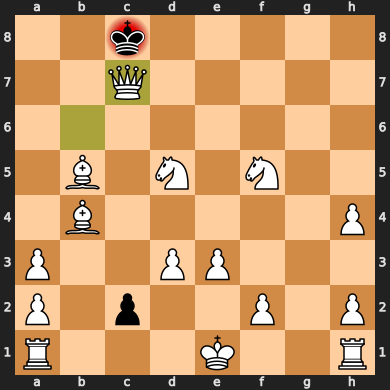

In [ ]:
if board.result() == "1/2-1/2":
    print("-----------------------DRAW-----------------------")
# check if white wins
elif board.result() == "1-0":
    print("-----------------------WHITE WINS-----------------------")
# check if black wins
elif board.result() == "-----------------------0-1-----------------------":
    print("BLACK WINS")

print("\n")
board

In [ ]:
res = ""
aux = True
cont = 1
for i in range(0, len(moves)):
  if aux:
    res += str(cont) + ". " + moves[i] + " "
    aux = False
  else:
    res += moves[i] + " "
    aux = True
    cont = cont + 1


print(str(res))

1. Nf3 g5 2. Nc3 g4 3. Ne5 b5 4. Nxb5 Na6 5. e3 Nb8 6. Qxg4 h6 7. Nxf7 Rh7 8. Nxd8 h5 9. Qxg8 h4 10. Qxh7 h3 11. Nf7 a6 12. Qg6 Ra7 13. Nxa7 a5 14. Nxc8 a4 15. gxh3 a3 16. bxa3 Na6 17. Bxa6 c5 18. Bb2 c4 19. Bc3 d5 20. h4 Kd7 21. Nb6+ Ke8 22. Nxd5 Kd7 23. Bb5+ Kc8 24. Qb6 Bh6 25. Nxh6 e5 26. Nf5 e4 27. Bb4 c3 28. d3 exd3 29. cxd3 c2 30. Ba6+ Kd7 31. Bb5+ Kc8 32. Ba6+ Kd7 33. Bb5+ 


In [ ]:
def minimax2(board, depth):
    if depth == 0 or board.is_game_over():
        # If the game ends return heuristic value
        return None, getPiecesValue(board)

    # If it is white turn's we maximize
    if board.turn:
        maxEval = float('-inf')
        bestMove = None
        for move in board.legal_moves:
            board.push(move)
            eval = minimax2(board, depth - 1)[1]
            board.pop()
            #Find the maximum value
            if eval > maxEval:
                maxEval = eval
                bestMove = move
        return bestMove, maxEval
    # In black's turn we minimize
    else:
        minEval = float('inf')
        bestMove = None
        for move in board.legal_moves:
            board.push(move)
            eval = minimax2(board, depth - 1)[1]
            board.pop()

            #Find the minimum value
            if eval < minEval:
                minEval = eval
                bestMove = move
        return bestMove, minEval

In [ ]:
board = chess.Board()
moves = []
cont = 1

# While game doesn't ends
while not board.is_game_over() or board.can_claim_draw():

  # White move

  # Get move
  move, eval = minimax(board, 2)
  move = board.san(move)
  # Make move
  board.push_san(move)
  moves.append(move)
  print("---------[",cont,"]---------")
  print("WHITE-------------->" + move)

  # Black move
  if board.is_game_over() or board.can_claim_draw():
      break;
  
  # Get move
  move2, eval = minimax2(board, 2)
  # Make move
  move2 = board.san(move2)
  board.push_san(move2)
  moves.append(move2)
  print("BLACK-------------->" + move2 + "\n")
  print(board)
  print("\n")
  cont += 1

---------[ 1 ]---------
WHITE-------------->Nf3
BLACK-------------->Nh6

r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R


---------[ 2 ]---------
WHITE-------------->Nc3
BLACK-------------->Rg8

r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . N . . N . .
P P P P P P P P
R . B Q K B . R


---------[ 3 ]---------
WHITE-------------->e3
BLACK-------------->Rh8

r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . N . P N . .
P P P P . P P P
R . B Q K B . R


---------[ 4 ]---------
WHITE-------------->Nb5
BLACK-------------->Rg8

r n b q k b r .
p p p p p p p p
. . . . . . . n
. N . . . . . .
. . . . . . . .
. . . . P N . .
P P P P . P P P
R . B Q K B . R


---------[ 5 ]---------
WHITE-------------->a4
BLACK-------------->Rh8

r n b q k b . r
p p p p p p p p
. . . . . . . n
. N . . . . . .
P . . . . . . .
. . . . P N . .
. P P P . P P P
R . B

-----------------------WHITE WINS-----------------------




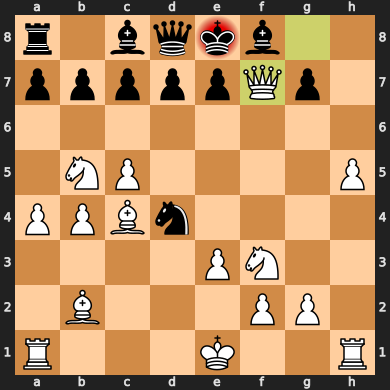

In [ ]:
if board.result() == "1/2-1/2":
    print("-----------------------DRAW-----------------------")
# check if white wins
elif board.result() == "1-0":
    print("-----------------------WHITE WINS-----------------------")
# check if black wins
elif board.result() == "-----------------------0-1-----------------------":
    print("BLACK WINS")

print("\n")
board

In [ ]:
res = ""
aux = True
cont = 1
for i in range(0, len(moves)):
  if aux:
    res += str(cont) + ". " + moves[i] + " "
    aux = False
  else:
    res += moves[i] + " "
    aux = True
    cont = cont + 1


print(str(res))

1. Nf3 Nh6 2. Nc3 Rg8 3. e3 Rh8 4. Nb5 Rg8 5. a4 Rh8 6. Be2 Rg8 7. h4 Rh8 8. c4 Rg8 9. h5 Rh8 10. b3 Rg8 11. Ba3 Rh8 12. c5 Rg8 13. b4 Rh8 14. d4 Rg8 15. Qc2 Rh8 16. Bb2 Rg8 17. Qxh7 Rh8 18. Qxh8 Ng8 19. Qxg8 Nc6 20. Bc4 Nxd4 21. Qxf7# 
